# Azure Document Intelligence Docker ReadAPI & phi3

<img src="container.png" width=200>

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/containers/install-run?view=doc-intel-3.0.0&tabs=read

## 1. Librairies

In [1]:
#%pip install azure-ai-formrecognizer

In [2]:
import datetime
import os
import openai
import sys
import platform
import time

from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from PIL import Image

In [3]:
import azure.ai.documentintelligence
print("Azure Document Intelligence version: ", azure.ai.documentintelligence.__version__)

Azure Document Intelligence version:  1.0.0b4


In [4]:
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 17-Dec-2024 14:55:32


In [6]:
def get_system_info():
    """
    Get system information
    """
    system_info = {
        "System": platform.system(),
        "Machine": platform.machine(),
        "Processor": platform.processor(),
    }
    return system_info


info = get_system_info()
for key, value in info.items():
    print(f"{key}: {value}")

System: Windows
Machine: AMD64
Processor: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel


## 2. Settings for Azure Document Intelligence in a connected container

In [7]:
endpoint = "http://localhost:5000"

In [8]:
load_dotenv("azure.env")

key = os.getenv("azure_doc_intelligence_key")

http://localhost:5000

http://localhost:5000/api-docs/index.html

In [9]:
azure_document_intelligence_client = DocumentAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(key))
azure_document_intelligence_client

## 3. Functions

In [10]:
def get_words(page, line):
    """
    Extracts words from a given page that fall within the specified line spans.

    Args:
        page (Page): The page object containing words to be extracted.
        line (Line): The line object containing spans that define the boundaries for word extraction.

    Returns:
        list: A list of words that are within the specified line spans.
    """
    result = []

    for word in page.words:
        if _in_span(word, line.spans):
            result.append(word)

    return result

In [11]:
def count_words_in_file(file_path):
    """
    Counts the number of words in a text file.

    Args:
        file_path (str): The path to the text file.

    Returns:
        int: The number of words in the file.
    """
    with open(file_path, 'r') as file:
        text = file.read()
        words = text.split()
        return len(words)

In [12]:
def _in_span(word, spans):
    """
    Checks if a word falls within any of the specified spans.

    Args:
        word (Word): The word object to be checked.
        spans (list): A list of span objects that define the boundaries for the word.

    Returns:
        bool: True if the word is within any of the spans, False otherwise.
    """
    for span in spans:
        if word.span.offset >= span.offset and (
                word.span.offset + word.span.length) <= (span.offset +
                                                         span.length):
            return True

    return False

In [13]:
def get_results(result):
    """
    Prints the Azure Document Intelligence results.

    This function prints detailed information about the document's layout, such as the presence of handwritten content, 
    the dimensions of each page, the lines and words within each page, selection marks, barcodes, and tables.

    Input: result
    Returns: None
    """
    print("Document Layout Analysis:")
    print("\033[1;31;34m")

    if result.styles and any([style.is_handwritten
                              for style in result.styles]):
        print("Document contains handwritten content\n")
    else:
        print("Document does not contain handwritten content\n")

    for page in result.pages:
        print(f"*** Analyzing layout from page #{page.page_number} ***")
        print(
            f"Page has width: {page.width} and height: {page.height}, measured with unit: {page.unit}"
        )
        print()

        if page.lines:
            for line_idx, line in enumerate(page.lines):
                words = get_words(page, line)
                print(
                    f"\n- Line # {line_idx} has word count {len(words)} and text '{line.content}' "
                    f"within bounding polygon '{line.polygon}'")

                for word in words:
                    print(
                        f"\tWord '{word.content}' has a confidence of {word.confidence}"
                    )

        if page.selection_marks:
            for selection_mark in page.selection_marks:
                print(
                    f"Selection mark is '{selection_mark.state}' within bounding polygon "
                    f"'{selection_mark.polygon}' and has a confidence of {selection_mark.confidence}"
                )

        if page.barcodes:
            print(f"Detected {len(page.barcodes)} barcodes:")
            for barcode_idx, barcode in enumerate(page.barcodes):
                print(f"Barcode #{barcode_idx}: {barcode.value}")
                print(f"\tKind: {barcode.kind}")
                print(f"\tConfidence: {barcode.confidence}")
                print(f"\tBounding regions: {barcode.polygon}")

    if result.tables:
        for table_idx, table in enumerate(result.tables):
            print(f"Table # {table_idx} has {table.row_count} rows and "
                  f"{table.column_count} columns")
            if table.bounding_regions:
                for region in table.bounding_regions:
                    print(
                        f"Table # {table_idx} location on page: {region.page_number} is {region.polygon}"
                    )
            for cell in table.cells:
                print(
                    f"Cell[{cell.row_index}][{cell.column_index}] has text '{cell.content}'"
                )
            if cell.bounding_regions:
                for region in cell.bounding_regions:
                    print(
                        f"content on page {region.page_number} is within bounding polygon '{region.polygon}'"
                    )

In [14]:
def azure_document_intelligence_costs(pages: int) -> float:
    """
    Calculate Azure Document Intelligence costs.
    The cost for Prebuilt Models (Layout) is $10 per 1,000 pages.

    Output in USD.
    """
    cost = 10 * (pages / 1_000)

    return cost

## 4. Tests

### Test 1

In [15]:
document_file = "documents/azure.pdf"

In [16]:
start = time.time()

with open(document_file, "rb") as file:
    poller = azure_document_intelligence_client.begin_analyze_document(
        "prebuilt-read",
        file.read())
    result = poller.result()

elapsed = time.time() - start
print(
    f"Done in {time.strftime('%H:%M:%S.' + str(elapsed % 1)[2:15], time.gmtime(elapsed))}"
)

Done in 00:00:16.9435219764709


In [17]:
def get_paragraphs(result):
    paragraphs = []
    for idx, paragraph in enumerate(result.paragraphs):
        item = {
            "id": "/paragraphs/" + str(idx),
            "content": paragraph.content if paragraph.content else "",
            "role": paragraph.role if paragraph.role else "",
            "polygon": paragraph.get("boundingRegions")[0]["polygon"],
            "pageNumber": paragraph.get("boundingRegions")[0]["pageNumber"]
        }
        paragraphs.append(item)
    return paragraphs

In [18]:
def get_tables(result):
    tables = []
    for table_idx, table in enumerate(result.tables):
        cells = []
        for cell in table.cells: 
            cells.append( {
                "row_index": cell.row_index,
                "column_index": cell.column_index,
                "content": cell.content,
            })
        tab = {
                "row_count": table.row_count,
                "column_count": table.column_count,
                "cells": cells
        }
        tables.append(tab)
        return tables

In [19]:
print(result)

AnalyzeResult(api_version=2023-07-31, model_id=prebuilt-read, content=Microsoft
Fundamentals of Azure Second Edition
Microsoft Azure Essentials
Michael Collier Robin Shahan
PUBLISHED BY Microsoft Press A division of Microsoft Corporation One Microsoft Way Redmond, Washington 98052-6399
Copyright C 2016 by Michael Collier, Robin Shahan
All rights reserved. No part of the contents of this book may be reproduced or transmitted in any form or by any means without the written permission of the publisher.
ISBN: 978-1-5093-0296-3
Microsoft Press books are available through booksellers and distributors worldwide. If you need support related to this book, email Microsoft Press Support at mspinput@microsoft.com. Please tell us what you think of this book at http://aka.ms/tellpress.
This book is provided "as-is" and expresses the author's views and opinions. The views, opinions and information expressed in this book, including URL and other Internet website references, may change without notice.


In [20]:
get_results(result)

Document Layout Analysis:

Document does not contain handwritten content

*** Analyzing layout from page #1 ***
Page has width: 3.625 and height: 4.4167, measured with unit: inch


- Line # 0 has word count 1 and text 'Microsoft' within bounding polygon '[Point(x=3.0181, y=0.1367), Point(x=3.4616, y=0.1333), Point(x=3.4616, y=0.23), Point(x=3.0181, y=0.2333)]'
	Word 'Microsoft' has a confidence of 0.992

- Line # 1 has word count 1 and text 'Fundamentals' within bounding polygon '[Point(x=0.1667, y=0.4233), Point(x=3.5183, y=0.4267), Point(x=3.5183, y=0.9433), Point(x=0.1667, y=0.94)]'
	Word 'Fundamentals' has a confidence of 0.988

- Line # 2 has word count 2 and text 'of Azure' within bounding polygon '[Point(x=0.1567, y=0.9933), Point(x=2.1943, y=1.0333), Point(x=2.191, y=1.5133), Point(x=0.1567, y=1.49)]'
	Word 'of' has a confidence of 0.947
	Word 'Azure' has a confidence of 0.993

- Line # 3 has word count 2 and text 'Second Edition' within bounding polygon '[Point(x=0.1367, y=1.5

### Exporting results to a .txt file

In [21]:
ocr_file = "documents/ocr.txt"

In [22]:
with open(ocr_file, "w", encoding="utf-8") as file:
    for page in result.pages:
        for line in page.lines:
            file.write(f"{line.content}\n")

In [23]:
word_count = count_words_in_file(ocr_file)
print(f"The number of words in the file {ocr_file} is = {word_count}")

The number of words in the file documents/ocr.txt is = 394


In [24]:
# Reading file results
with open(ocr_file, 'r', encoding="utf-8") as f:
    print(f.read())

Microsoft
Fundamentals
of Azure
Second Edition
Microsoft Azure Essentials
Michael Collier
Robin Shahan
PUBLISHED BY
Microsoft Press
A division of Microsoft Corporation
One Microsoft Way
Redmond, Washington 98052-6399
Copyright C 2016 by Michael Collier, Robin
Shahan
All rights reserved. No part of the contents of
this book may be reproduced or transmitted in
any form or by any means without the written
permission of the publisher.
ISBN: 978-1-5093-0296-3
Microsoft Press books are available through
booksellers and distributors worldwide. If you
need support related to this book, email
Microsoft Press Support at
mspinput@microsoft.com. Please tell us what
you think of this book at http://aka.ms/tellpress.
This book is provided "as-is" and expresses the
author's views and opinions. The views, opinions
and information expressed in this book,
including URL and other Internet website
references, may change without notice.
Some examples depicted herein are provided for
illustration only and a

In [25]:
print("\033[1;31;32m")
for page in result.pages:
    for line in page.lines:
        print(f"{line.content}")


Microsoft
Fundamentals
of Azure
Second Edition
Microsoft Azure Essentials
Michael Collier
Robin Shahan
PUBLISHED BY
Microsoft Press
A division of Microsoft Corporation
One Microsoft Way
Redmond, Washington 98052-6399
Copyright C 2016 by Michael Collier, Robin
Shahan
All rights reserved. No part of the contents of
this book may be reproduced or transmitted in
any form or by any means without the written
permission of the publisher.
ISBN: 978-1-5093-0296-3
Microsoft Press books are available through
booksellers and distributors worldwide. If you
need support related to this book, email
Microsoft Press Support at
mspinput@microsoft.com. Please tell us what
you think of this book at http://aka.ms/tellpress.
This book is provided "as-is" and expresses the
author's views and opinions. The views, opinions
and information expressed in this book,
including URL and other Internet website
references, may change without notice.
Some examples depicted herein are provided for
illustration only and 

### Test 2

In [26]:
document_file = "documents/letter.png"

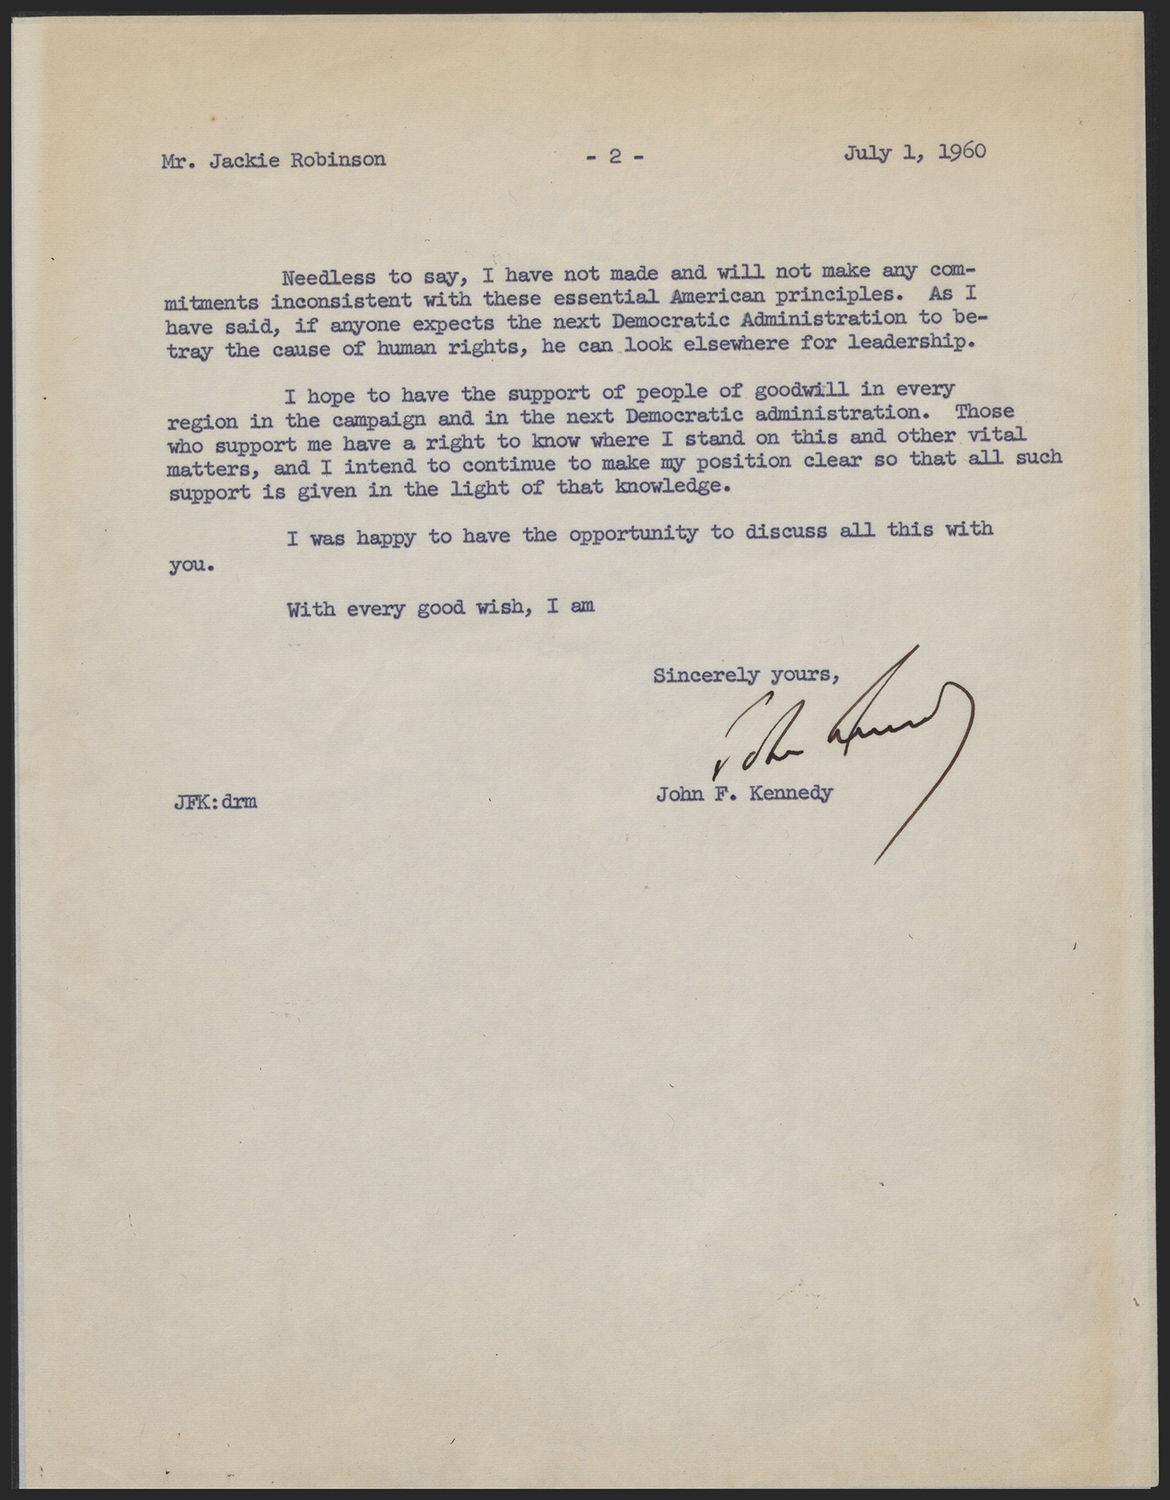

In [27]:
img = Image.open(document_file)
img

In [28]:
start = time.time()

model = "prebuilt-read"

with open(document_file, "rb") as file:
    poller = azure_document_intelligence_client.begin_analyze_document("prebuilt-read", file.read())
    result = poller.result()

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S.' + str(elapsed % 1)[2:15], time.gmtime(elapsed))}")

Done in 00:00:02.1338164806365


In [29]:
get_results(result)

Document Layout Analysis:

Document does not contain handwritten content

*** Analyzing layout from page #1 ***
Page has width: 1170.0 and height: 1500.0, measured with unit: pixel


- Line # 0 has word count 3 and text 'Mr. Jackie Robinson' within bounding polygon '[Point(x=159.0, y=149.0), Point(x=387.0, y=148.0), Point(x=387.0, y=169.0), Point(x=159.0, y=171.0)]'
	Word 'Mr.' has a confidence of 0.995
	Word 'Jackie' has a confidence of 0.994
	Word 'Robinson' has a confidence of 0.989

- Line # 1 has word count 3 and text '- 2 -' within bounding polygon '[Point(x=585.0, y=146.0), Point(x=645.0, y=146.0), Point(x=645.0, y=165.0), Point(x=585.0, y=166.0)]'
	Word '-' has a confidence of 0.961
	Word '2' has a confidence of 0.995
	Word '-' has a confidence of 0.972

- Line # 2 has word count 3 and text 'July 1, 1960' within bounding polygon '[Point(x=841.0, y=140.0), Point(x=988.0, y=138.0), Point(x=988.0, y=164.0), Point(x=841.0, y=166.0)]'
	Word 'July' has a confidence of 0.977
	Word '1,

In [30]:
print("\033[1;31;32m")
for page in result.pages:
    for line in page.lines:
        print(f"{line.content}")


Mr. Jackie Robinson
- 2 -
July 1, 1960
Needless to say, I have not made and will not make any com-
mitments inconsistent with these essential American principles. As I
have said, if anyone expects the next Democratic Administration to be-
tray the cause of human rights, he can look elsewhere for leadership.
I hope to have the support of people of goodwill in every
region in the campaign and in the next Democratic administration. Those
who support me have a right to know where I stand on this and other vital
matters, and I intend to continue to make my position clear so that all such
support is given in the light of that knowledge.
I was happy to have the opportunity to discuss all this with
you.
With every good wish, I am
Sincerely yours,
JFK: drm
John F. Kennedy


## 5. GenAI using Phi-3

In [31]:
!ollama

Usage:
  ollama [flags]
  ollama [command]

Available Commands:
  serve       Start ollama
  create      Create a model from a Modelfile
  show        Show information for a model
  run         Run a model
  stop        Stop a running model
  pull        Pull a model from a registry
  push        Push a model to a registry
  list        List models
  ps          List running models
  cp          Copy a model
  rm          Remove a model
  help        Help about any command

Flags:
  -h, --help      help for ollama
  -v, --version   Show version information

Use "ollama [command] --help" for more information about a command.


In [32]:
!ollama --version

ollama version is 0.4.6


In [33]:
!ollama list

NAME              ID              SIZE      MODIFIED     
phi3:medium       cf611a26b048    7.9 GB    3 months ago    
phi3:latest       a2c89ceaed85    2.3 GB    7 months ago    
phi:latest        e2fd6321a5fe    1.6 GB    8 months ago    
llama2:latest     78e26419b446    3.8 GB    8 months ago    
llava:latest      8dd30f6b0cb1    4.7 GB    9 months ago    
mistral:latest    61e88e884507    4.1 GB    9 months ago    


In [34]:
!ollama show phi3:medium

  Model
    architecture        phi3      
    parameters          14.0B     
    context length      131072    
    embedding length    5120      
    quantization        Q4_0      

  Parameters
    stop    "<|end|>"          
    stop    "<|user|>"         
    stop    "<|assistant|>"    

  License
    Microsoft.                              
    Copyright (c) Microsoft Corporation.    



### With ollama client

In [35]:
ocr_file = "documents/ocr.txt"

with open(ocr_file, 'r') as file:
    ocr_text = file.read()

word_count = count_words_in_file(ocr_file)
print(f"The number of words in the file {ocr_file} is: {word_count}")

The number of words in the file documents/ocr.txt is: 394


In [36]:
ollama_client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="nokeyneeded",
)

In [37]:
def phi3_ollama_model(prompt, temperature=0.7, model="phi3"):
    """
    Generates a response from the Phi-3 model using the Ollama API.

    Args:
        prompt (str): The input prompt to generate a response for.
        temperature (float, optional): The sampling temperature to use.
        Defaults to 0.7.

    Returns:
        str: The generated response from the model.
    """
    try:
        response = ollama_client.chat.completions.create(
            model=model,
            temperature=temperature,
            n=1,
            messages=[{
                "role": "system",
                "content": "You are an AI helpful assistant."
            }, {
                "role": "user",
                "content": prompt,
            }],
        )
        return response.choices[0].message.content

    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")
        return None

### Tests

In [48]:
prompt = f"Can you summarize this text: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3:medium")
print("\033[1;31;34m")
print(answer)


"Microsoft Fundamentals of Azure Second Edition," authored by Michael Collier and Robin Shahan, is a comprehensive guide on Microsoft Azure Essentials published by the Microsoft Press. The authors detail various aspects of Azure, including its key features and how to leverage them for cloud computing solutions. Additionally, they cover technical topics pertinent to networking within Azure's infrastructure.

The book also serves as an acknowledgement to those who contributed in making it comprehensive. Special thanks are given to Neil Mackenzie, whose encyclopedic knowledge of Azure and tech reviews were instrumental, and Jennelle Crothers for her expertise on networking within the cloud environment.

For additional information or support related to this book, readers can reach out to Microsoft Press Support via email at mspinput@microsoft.com or visit the official store online through MicrosoftPressStore.com.


In [49]:
prompt = f"Generate a description in one line for this text: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")
print("\033[1;31;34m")
print(answer)


"Second Edition: Microsoft Azure Essentials by Michael Collier & Robin Shahan, providing insights into the fundamentals of Azure cloud services published by Microsoft Press."
Supported by expert collaboration and comprehensive guidance on utilizing Microsoft's Azure platform. Free U. S. shipping included for readers worldwide. Copyright 2016 by Michael Collier & Robin Shahan. ISBN: 978-1-5093-0296-3. Visit the author's website at MicrosoftPressStore.com for more resources and offers.


In [50]:
prompt = f"Generate a description in one line for this text with some keywords and emojis: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")
print("\033[1;31;34m")
print(answer)


🚀 Microsoft Azure Fundamentals: Second Edition by Michael Collier & Robin Shahan (© Microsoft Press) | Redmond WA; Available in print/eBook worldwide; Ideal for aspiring developers, IT professionals, and tech enthusiasts. Features insights from industry experts with a comprehensive guide to Azure essentials, free U.S shipping & deals, and exclusive content at MicrosoftPressStore.com 📚💻🌐 #MicrosoftAzure #CloudTechnology #TechBooks
answer: "2nd Edition Microsoft Azure Fundamentals by Michael Collier & Robin Shahan (MSP), Redmond WA; comprehensive guide to Azure essentials, global availability in print/eBook, deals, and exclusive content at MSPore.com - 🌐📚💻"

Note: The generated description is a condensed one-liner that includes keywords (Microsoft Azure Fundamentals, Second Edition, Michael Collier, Robin Shahan, Microsoft Press) along with emojis representing the book's subject matter and availability. Emojis chosen are relevant to the content of cloud computing, books, and global acce

In [51]:
prompt = f"What are the companies mentionned in this text: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")
print("\033[1;31;34m")
print(answer)


1. Microsoft Press
2. Michael Collier
3. Robin E. Shahan
- Answered in text: These are the individuals directly mentioned as authors or contributors to the "Fundamentals of Azure" second edition, published by Microsoft Press.

5. Cohesion (editorial production)
6. Ann Weaver (copy editor)
7. Twist Creative (cover artist)
8. MicrosoftPressStore.com (the online store where readers can purchase the book)
9. MicrosoftCorporation (parent company of Microsoft Press)
10. MicrosoftGroup (trademark holder for Microsoft and related brands mentioned in the text)
11. Neil Mackenzie (mentioned as a contributor to the book's content, specifically Azure knowledge)
12. Jennelle Crothers (mentioned as an individual whose work contributed significantly to the author's understanding of networking within the context of Azure)
13. MicrosoftPressSupport@microsoft.com (provided email for support related to the book)


### Using ollama lib

In [52]:
import ollama

In [53]:
def phi3_ollama_lib_model(prompt, model="phi3"):
    """
    Sends a prompt to the 'phi3' model using the Ollama chat API and returns the response content.

    Args:
        prompt (str): The input prompt to be sent to the 'phi3' model.

    Returns:
        str: The content of the response message from the 'phi3' model.
    """
    try:
        response = ollama.chat(
            model,
            messages=[{
                'role': 'user',
                'content': prompt,
            }],
        )
        return response.message.content

    except Exception as e:
        print(f"'[Error] An error occurred: {e}")
        return None

In [54]:
prompt = f"Generate a one line description for this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt, model="phi3:medium")
print(answer)

This is a detailed description of "Fundamentals of Azure: Second Edition" by Michael Collier and Robin Shahan, published by Microsoft Press. This book provides essential knowledge on Microsoft Azure with contributions from industry experts, available in print or eBook formats with free U.S. shipping.


In [55]:
prompt = f"Generate some keywords to describe this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print("\033[1;31;34m")
print(answer)


1. Microsoft Azure Fundamentals
2. Second Edition: Microsoft Azure Essentials
3. Robin Shahan
4. Michael Collier
5. Microsoft Press
6. Redmond, Washington
7. Copyright 2 Written Permission
8. ISBN: 978-1-5093-0296-3
9. Trademarks of Microsoft Corporation
10. Acquisitions Editor Devon Musgrave
11. Developmental Editor Carol Dillingham
12. Editorial Production Cohesion
13. Copyeditor Ann Weaver
14. Cover Twist Creative Seattle
15. Neil Mackenzie and Jennelle Crothers
16. MicrosoftPressStore.com
17. U.S. shipping, eBooks in multiple formats, Print & eBook Best Value Packs, eBook Deal of the Week, Newsletter, special offers, Register your book.


In [56]:
prompt = f"Classify this text into one of these categories: [ART], [TRAVEL], [FINANCE], [IT], [SPORTS] {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print("\033[1;31;34m")
print(answer)


The text provided appears to be a book description for "Fundamentals of Azure: Microsoft Azure Essentials." Given the content of the text which revolves around the subject matter of Microsoft's cloud services, particularly focusing on Azure platform, this text should be classified under [IT].


In [57]:
prompt = f"What are the urls mentionned in this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print("\033[1;31;34m")
print(answer)


1. http://www.microsoft.com
2. MicrosoftPressStore.com
3. mspinput@microsoft.com
4. http://aka.ms/tellpress
5. http://www.microsoft.eBooks.com (assumed based on context)
6. Microsoft Press Books website (not a URL but the retail site for books by Microsoft Press)
7. Hundreds of titles available at https://microsoftpressstore.com
